# Sequence Processing with Recurrent Neural Networks

## Background

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies).

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks (RNNs) are an example of such machinery. For this assignment, you will construct a recurrent neural network that will predict properties of the upcoming (not yet seen) text. You know this situation from language models, which try to predict the next word in a sequence given context. What language models do is provide a conditional probability distribution over the whole vocabulary of the upcoming word. Here, however, we will simplify our life. Rather than trying to predict the upcoming word, **we will construct a recurrent neural network that will predict the part-of-speech tag (POS tag) of the upcoming word.** That is, the network will build a conditional probability distribution over the full list of POS tags of the upcoming word given the preceding context.

Let's look at a few examples to make it clear what the model will be doing and to gauge intuion on how difficult this is. Sometimes, the task can be fairly easy. For instance, if the sentence starts as 'I want to...' then the next POS tag (the POS tag of the next word given this context) is very likely to be a verb in its base form (e.g., 'sleep'). Other times, it is harder. For instance, if the context is 'John left...' the continuation could be almost any POS tag, from the period (which has its own tag) to a preposition (as in 'John left at noon') through pronouns (as in 'John left us') to determiners (as in 'John left the city').

This task can be seen as simplified case of using an RNN as a language model. A good reference point for RNNs as language models and for RNNs as labellers of POS tags is in Jurafsky and Martin [Chapter 13](https://web.stanford.edu/~jurafsky/slp3/13.pdf).

You might wonder why anyone would bother modeling such prediction. One reason is that the resulting model can be seen as approximating human behavior, in this case, human behavior in reading and listening. It is a well-known fact that when we process text (or speech), we do not just passively wait for the incoming information. We are immediately interpreting and we predict what will be coming next. This prediction has various levels of abstraction: we might predict concrete words, but we also predict abstract properties of such words, such as gender or their phonological structures. The task that you do here can be seen as one step in this prediction process. We will try to see whether the resulting RNN model is in any way similar to humans.

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment or `NotImplemented`.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily mean that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debugging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">Following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>

# <font color="red">Contributions</font>

* Diego Farinella: 3,4,5,6,7,8
* Simon van der Knaap: 1,2,4,6,7,9,10


## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks that accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors.

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs.
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing.

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ are its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ are the parametric tensors to be learned.

In [ ]:
# Importing - all packages needed in this assignment

# numpy for data analysis - should be lower than 2.0, otherwise there are compatibility issues with spacy;

import pickle # pickle for loading existing python objects
from collections import Counter, defaultdict # counter for simple counting models

import numpy as np
import pandas as pd

# torch - for NNs
import torch
print(f"torch ver={torch.__version__}\nnumpy ver={np.__version__}")
from torch import FloatTensor, LongTensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# sklearn for easy split of training and testing
from sklearn.model_selection import train_test_split

# matplotlib for plotting results
from matplotlib import pyplot as plt

# typing to indicate types in code
from typing import Tuple, List, Callable, Optional, Dict
torch.set_printoptions(precision=8) #to increase precision of printing floats

# spacy for pretrained vectors
import spacy
print(f"spacy ver={spacy.__version__}")

# tqdm to show progress bars during (long) loops
from tqdm import tqdm

torch ver=2.8.0+cu126
numpy ver=2.0.2
spacy ver=3.8.7


We will use the following function to concisely convert torch tensors to numpy arrays before printing tensors.

In [ ]:
# Conversion between tensor and np
def tr2np(tensor):
    """Convert torch tensor into numpy array"""
    return tensor.detach().cpu().numpy()

In [ ]:
# define a global variable for processing unit
# set it to cuda if gpu is available
# Your implementations of models and functions should work with both, gpu and cpu
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

#### TASK 1
Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs an SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

<font color="red">_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [ ]:
# @title c1 [2pt]
# simple and slow RNN

class MySRN(torch.nn.Module):
    """
    SRN module, hand-coded.
    The dimension and activation argumenst are self-descriptive.
    device points to the device ('cpu' or 'cuda') on which the tensors and computations on them will be allocated.
    !!! Make sure to place tensors on the device
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        hidden_activation: Callable[[FloatTensor], FloatTensor],
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str = 'cpu',
        seed: int = 42
    ) -> None:
        super().__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        #
        torch.manual_seed(seed)
        self.x_to_h = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias=True)

        self.to(device)

    def step(self, x: FloatTensor, hprev: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        """
        step performs a computational step, accepting x_t and hprev (h_{t-1}) and producing h_t and y_t
        """
        h_t = self.hidden_activation(self.x_to_h(x) + self.h_to_h(hprev))
        y_t = self.output_activation(self.h_to_y(h_t))

        return h_t, y_t

    def forward(self, X: List[FloatTensor], hprev: FloatTensor) -> List[FloatTensor]:
        """
        forward accepts a List of inputs X, an initial hidden vector hprev (h_{t−1}) and
        iteratively applies step until the input sequence is exhausted,
        returning a List of outputs Y (of the same length as X).
        """
        # for each output element y_t, detach it before appending to Y
        Y = []
        h_t = hprev

        for x_t in X:
            h_t, y_t = self.step(x_t, h_t)
            Y.append(y_t.detach())

        return Y

<font color="red">The following toy RNN helps you to verify whether your implementation is correct.</font>  
Use the numbers below in the functions, and you can manually verify the output of the RNN.  
This manual check will help you to see whether you are understanding the calculations behind the RNN.

In [ ]:
# TEST c1
# note that the default seed parameter makes output of the cell deterministic
# create our RNN with some short dimensions and ReLU activations
my_rnn = MySRN(3, 2, 1, torch.nn.ReLU(), torch.nn.ReLU(), device='cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(my_rnn.x_to_h.weight), "\nbias:", my_rnn.x_to_h.bias)
print("H->H", "\nmatrix:\n", tr2np(my_rnn.h_to_h.weight), "\nbias:", tr2np(my_rnn.h_to_h.bias))
print("H->Y", "\nmatrix:\n", tr2np(my_rnn.h_to_y.weight), "\nbias:", tr2np(my_rnn.h_to_y.bias))

# running the RNN on a sample input of size 2 and an initial hidden vector
output = my_rnn.forward([FloatTensor([0,0,1]), FloatTensor([1,0,0])],
                         FloatTensor([1,1]))

print("output:\n", output)

X->H 
matrix:
 [[ 0.44140652  0.47920528 -0.13525727]
 [ 0.53036046 -0.1264995   0.11650391]] 
bias: None
H->H 
matrix:
 [[-0.3442585   0.41527155]
 [ 0.62334496 -0.5187534 ]] 
bias: [0.6146145  0.13234161]
H->Y 
matrix:
 [[0.5224168  0.09576388]] 
bias: [0.34095848]
output:
 [tensor([0.66232765]), tensor([0.94909447])]


In practice, we do not need to write our own functions for common RNN architectures.
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN by default can accept a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of tensors as in `MySRN`
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `"tanh"` or `"relu"` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

**Read the [RNN documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) (!) for further details.**

A brief example is given below.

In [ ]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity="tanh")
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim).

In [ ]:
# delete temporary variabels so that they won't be accidentally used by the rest of the code
try:
    del MySRN, rnn, X, h, my_rnn, output
except NameError:
    pass  # Variable doesn't exist; ignore

#### TASK 2
Create a new class, FastSRN, which uses the `RNN` wrapper and the `h_to_y` transformation.  
Keep the default value `batch_first=False` for the RNN.

In [ ]:
# @title c2 [2pt]
# faster RNN

class FastSRN(torch.nn.Module):
    """
    SRN module using RNN class in torch.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        output_activation: Callable[[FloatTensor], FloatTensor],
        hidden_activation: str = 'tanh',
        num_layers: int = 1,
        device: str = 'cpu', #!!! Don't forget to use the device argument
        seed: int = 42
    ) -> None:
        torch.manual_seed(seed)
        super().__init__()
        self.output_activation = output_activation
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers, nonlinearity=hidden_activation, batch_first=False)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)

        self.to(device)

    def forward(self, X:FloatTensor, hprev: Optional[FloatTensor]=None) -> FloatTensor:
        """
        forward accepts a List of inputs represented as a tensor X,
        an initial hidden vector hprev (h_{t−1}),
        and iteratively applies step until the input sequence is exhausted,
        returning a List of outputs Y (of the same length as X).
        """
        h_t_seq, h_last = self.rnn(X, hprev)

        Y = self.h_to_y(h_t_seq)
        Y = self.output_activation(Y)

        return Y

##### Testing the new implementation

Let's see our new implementation in action.

Initialize a random input tensor $X$ that would correspond to 32 sequences (i.e., batch=32),  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimensional output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [ ]:
# TEST c2a
fast_srn = FastSRN(input_dim=16, hidden_dim=42, output_dim=2,
    output_activation=torch.nn.Softmax(dim=-1), device="cpu"
)
X = torch.rand(10, 32, 16)
y = fast_srn(X)
y.shape

torch.Size([10, 32, 2])

Again you can verify correctness of your implementation here, and as before, <font color="red">check whether it really does the computations what equations are describing.</font>

In [ ]:
# TEST c2b
torch.manual_seed(10)
# create our RNN with some short dimensions
fast_srn = FastSRN(3, 2, 2, output_activation=torch.nn.Softmax(dim=-1), hidden_activation='relu', device='cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_ih_l0), "\nbias:",  tr2np(fast_srn.rnn.bias_ih_l0))
print("H->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_hh_l0), "\nbias:", tr2np(fast_srn.rnn.bias_hh_l0))
print("H->Y", "\nmatrix:\n", tr2np(fast_srn.h_to_y.weight), "\nbias:", tr2np(fast_srn.h_to_y.bias))


# running the RNN on a sample input of size 2
output = fast_srn.forward(torch.FloatTensor([[[0,0,1]], [[1,0,0]]]))

print("output:\n", tr2np(output))

X->H 
matrix:
 [[ 0.5406104   0.5869042  -0.16565566]
 [ 0.6495563  -0.15492962  0.14268756]] 
bias: [0.6146145  0.13234161]
H->H 
matrix:
 [[-0.3442585   0.41527155]
 [ 0.62334496 -0.5187534 ]] 
bias: [0.5224168  0.09576388]
H->Y 
matrix:
 [[ 0.34095848 -0.09983712]
 [ 0.5450986   0.10451668]] 
bias: [-0.33010566  0.18024032]
output:
 [[[0.313369   0.686631  ]]

 [[0.25354943 0.7464506 ]]]


In [ ]:
try:
    del fast_srn, X, y, output
except NameError:
    pass  # Variable doesn't exist; ignore

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This, however, is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq\_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq\_len$_n$}, N, input_dim).

An example:

In [ ]:
x1 = torch.rand(1, 2)  # a sequence of 1, 2-dimensional item
x2 = torch.rand(4, 2)  # a sequence of 4, 2-dimensional items
x3 = torch.rand(2, 2)  # a sequence of 2, 2-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x1, x2, x3])

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([4, 3, 2])


Now compare the contents for better understanding.

In [ ]:
for i in [x1, x2, x3]: print(i)
print(f"\n{'After combining':=^50}\n\n{X}")

tensor([[0.26963168, 0.44136357]])
tensor([[0.29692084, 0.83168548],
        [0.10531491, 0.26949483],
        [0.35881263, 0.19936377],
        [0.54719156, 0.00616044]])
tensor([[0.95155454, 0.07526588],
        [0.88601369, 0.58320957]])

=================After combining==================

tensor([[[0.26963168, 0.44136357],
         [0.29692084, 0.83168548],
         [0.95155454, 0.07526588]],

        [[0.00000000, 0.00000000],
         [0.10531491, 0.26949483],
         [0.88601369, 0.58320957]],

        [[0.00000000, 0.00000000],
         [0.35881263, 0.19936377],
         [0.00000000, 0.00000000]],

        [[0.00000000, 0.00000000],
         [0.54719156, 0.00616044],
         [0.00000000, 0.00000000]]])


In [ ]:
try:
    del x1, x2, x3, X, i
except NameError:
    pass  # Variable doesn't exist; ignore

## Pretrained Word Embeddings
In the last assignment, we saw how to train our own word embeddings using a small toy corpus. Now, we will see how to easily get high-quality pretrained word vectors and how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`), or it is already preinstalled if using the Colab environment.

SpaCy comes with a lot of different-size models for different languages.

We will need to download the large English model for the exercises to follow. You can do it by simply running the magic command below.

In [ ]:
# @title download spacy lg
!python3 -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [ ]:
nlp = spacy.load("en_core_web_lg")

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays. [More info](https://spacy.io/models/en#en_core_web_lg) about vectors coming with `en_core_web_lg`.  
We can also check similarities between the vectors, e.g., `words` is more similar to `sentence` than to `this`.  
Note that these are static, aka non-contextualized, word embeddings.

In [ ]:
doc = nlp("this is a sentence of 7 words")  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
# vectors = [ t.vector for t in doc ] # or the same with list comprehension

print(f"We have {len(vectors)} vectors", end=", ")
print(f"each of shape {vectors[0].shape} and of type {type(vectors[0])}")

print(f"'{doc[6]}' is {doc[6].similarity(doc[3]):.2f} similar to '{doc[3]}' and {doc[6].similarity(doc[0]):.2f} similar to '{doc[0]}'")

We have 7 vectors, each of shape (300,) and of type <class 'numpy.ndarray'>
'words' is 0.57 similar to 'sentence' and 0.38 similar to 'this'


And then finally convert them into torch tensors.

In [ ]:
torch_vectors = torch.tensor(np.array(vectors))
# torch_vectors = torch.tensor(vectors) # this is also fine but might get an efficiency warning from torch
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [ ]:
# Example sentences.
sentences = ["This is a sentence", "This is another sentence."]

# Parallel processing with spacy.
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors.
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor.
tensors = list(map(lambda sentence_vectors: torch.tensor(np.array(sentence_vectors)), vectors))
print(tensors[0].shape)

torch.Size([4, 300])


Given our pretrained embeddings, we may represent sentences as _sequences of pretrained vectors_, which is exactly the format expected by an RNN. (That is, to be clear, our pretrained embeddings will be used as input vectors for our RNN.)

### Examining the data
First, let's load and inspect our data files.

The pickle file contains three items:
1. `sentences`: a List of strings (sentences)
2. `postags`: a List of Lists of strings (POS tags)
3. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)

In [ ]:
# Download files on the fly with the below two lines
!wget -nv -O pos-rnn-data.zip https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip
!unzip -o pos-rnn-data.zip

2025-11-09 16:16:01 URL:https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip [2162187/2162187] -> "pos-rnn-data.zip" [1]
Archive:  pos-rnn-data.zip
  inflating: TEST.p                  
  inflating: TRAIN.p                 


In [ ]:
import pickle
# we will use only TRAIN.p
with open("TRAIN.p", "rb") as f:
    sentences, postags, pos_to_int = pickle.load(f)

Let's sanity check that we have the same number of sentences as pos tag annotations and for each sentence and annotation pair, the number of tokens and tags are the same.

In [ ]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more.
Run the cell below with different values of `i` to get an idea of how the data looks like.

In [ ]:
i = 73
for tok, tag in zip(sentences[i].split(), postags[i]):
    print(f"{tok}/{tag}", end=' ')

The/DT Orwellian/NNP New/JJ World/NN Information/NN Order/NN would/MD give/VB government/NN officials/NNS rights/NNS against/IN the/DT press/NN ;/; journalists/NNS would/MD be/VB obliged/VBN to/TO kowtow/VB to/TO their/PRP$ government/NN ,/, which/WDT would/MD have/VB licensing/NN and/CC censorship/NN powers/NNS and/CC ,/, indeed/RB ,/, duties/NNS to/TO block/VB printing/NN of/IN wrong/JJ ideas/NNS ./. 

In [ ]:
try:
    del i, tok, tag, torch_vectors, vectors, f, doc, docs, tensors
except NameError:
    pass

#### TASK 3

The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and summarise by plotting their frequencies in the histogram: Only the top 20 most frequent POS tags sitting on the x axis and y axis marking their raw counts.  

Find what these tags mean linguistically and state what the top 6 POS tags represent. See https://www.eecis.udel.edu/~vijay/cis889/ie/pos-set.pdf for details.  
_Hint_: you can use pandas; the 7th and 8th most frequent tags are punctuation marks.

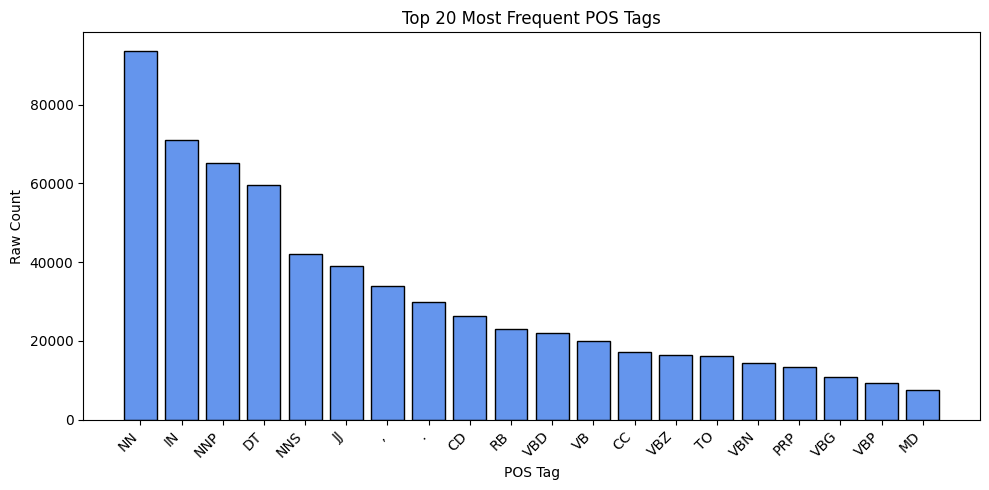

In [ ]:
# @title c3.1 [0pt]

# YOUR CODE HERE

all_tags = []
for seq in postags:
    for t in seq:
        all_tags.append(t)

tag_counts = Counter(all_tags)
top20 = tag_counts.most_common(20)


df = pd.DataFrame(top20, columns=["tag", "count"])


plt.figure(figsize=(10, 5))
plt.bar(df["tag"], df["count"], color="cornflowerblue", edgecolor="black")
plt.xlabel("POS Tag")
plt.ylabel("Raw Count")
plt.title("Top 20 Most Frequent POS Tags")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

We will explore the data further, which will lead us to two **baseline models** on predicting a POS tags of an upcoming word (!). The first model would simply predict the most frequent POS tag regardless of the input word sequence. We call such a model the most frequent tag (MFT) model.

<font color="red">When having an empty context, predicting a tag of an upcoming word is an unnatural task and represents a weird corner case. That's why predicting a tag of the first word should be always skipped in this tag prediction task.</font>  

Below is a function that takes training and test sets of POS tags and returns (i) the score of the MFT model on the test set, and (ii) the MFT based on the training set.    
Note that the function doesn't take training and test sets of sentences because the MFT model doesn't make use of word sequences.

In [ ]:
def mft_baseline(pos_train: List[List[str]], pos_test: List[List[str]]) -> Tuple[float, str]:
    """
    Takes training and test sets of POS tags and returns
    (i) the score of the MFT model on the test set, and
    (ii) the MFT, i.e., a tag, based on the training set.
    """
    from collections import Counter
    # get most frequent tag, which skips the first tag
    cnt = Counter([p for tags in pos_train for p in tags[1:]])
    mft_tag = cnt.most_common(1)[0][0]
    # evaluate on test. Not predicting the very first tag.
    correct = sum([ p == mft_tag for tags in pos_test for p in tags[1:]])
    score = correct / sum([len(tags[1:]) for tags in pos_test])
    return score, mft_tag

In [ ]:
# testing the function on the sample input
mft_score, mft = mft_baseline(postags[:24_000], postags[24_000:])
print(f"mft_score = {mft_score}, where mft = {mft}")

assert mft_score > 0.10

mft_score = 0.14548776310280517, where mft = NN


Another baseline model to predict POS tag would assign the most frequent POS tag given the single previous word. This baseline is called the unigram baseline. We will explore how much data would be accounted for this way.  

Complete the function `unigram_baseline` below. It takes usual input: training and test sets, each represented with list of sentences and list of the corresonding POS tags. Note that unlike the MFT baseline, the unigram baseline takes words into account. The function returns (i) the score that the unigram model "trained" on the training set obtains on the test set, and (ii) the unigram model that is represented as a [`defaultdict`](https://docs.python.org/3/library/collections.html#collections.defaultdict), where he default value is the most frequent tag that is predicted for the words unseen in the training set, but seen in the test set.

In [ ]:
# @title c3.2 [2pt]

def unigram_baseline(sen_train: List[str], pos_train: List[List[str]],
                     sen_test: List[str], pos_test: List[List[str]]) -> Tuple[float, defaultdict]:
    """
    Takes training and test sets, each represented with list of sentences and list of the corresonding POS tags.
    Note that unlike the MFT baseline, the unigram baseline takes words into account.
    """
    # you can reuse mft_baseline here to get the most frequent tag
    # YOUR CODE HERE

    _, mft_tag = mft_baseline(pos_train, pos_train)

    # Get the counts
    counts = defaultdict(Counter)

    for sent, tags in zip(sen_train, pos_train):
      tokens = sent.split()
      for i in range(1, len(tokens)):
        prev_word = tokens[i - 1]
        curr_tag = tags[i]
        counts[prev_word][curr_tag] += 1

    # Creating the unigram model
    unigram = defaultdict(lambda: mft_tag)
    for prev_word, tag_counter in counts.items():
      most_common_tag = tag_counter.most_common(1)[0][0]
      unigram[prev_word] = most_common_tag

    # Evaluating
    correct, total = 0, 0
    for sent, tags in zip(sen_test, pos_test):
      tokens = sent.split()
      for i in range(1, len(tokens)):
        prev_word = tokens[i-1]
        gold_tag  = tags[i]
        pred_tag  = unigram[prev_word]
        if (pred_tag == gold_tag):
          correct  += 1
        total    += 1

    score = correct / total if total else 0.0



    return score, unigram

In [ ]:
# TEST c3.2
# testing the function on the sample input
unigram_score, unigram = unigram_baseline(sentences[:24_000], postags[:24_000], sentences[24_000:], postags[24_000:])
print(f"unigram_score = {unigram_score}")

assert unigram_score > 0.30

unigram_score = 0.37197122521219506


In [ ]:
try:
    del mft_score, mft, unigram_score, unigram
except NameError:
    pass

### Tensorizing sentences
Next, we need to convert our data to numeric form. We will convert sentences to their tensor format, as done earlier.

<div class="alert alert-block alert-info">
<b>Important!</b>
Since the sentences are pre-tokenized with whitespace (e.g., <code>One , two , and three .</code> instead of <code>One, two, and three.</code>), we need to change the processing call to ensure the output vectors are aligned with our tokenization (otherwise SpaCy will tokenize it in its own way and might break the correspondence between tokens and POS tags).
</div>

In [ ]:
docs = [ spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()) for sentence in sentences ]

doc_vectors = [ np.array([word.vector for word in doc]) for doc in docs ]
doc_tensors = [ torch.tensor(sentence_vectors) for sentence_vectors in doc_vectors ]

# Try to understand what size this prints and why
print(doc_tensors[1].shape)

torch.Size([5, 300])


You might want to explore whether SpaCy provides non-trivial embeddings for every word or relies on a fallback for unknown words.

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [ ]:
pos_numeric = [ np.array([pos_to_int[pos] for pos in pos_sequence]) for pos_sequence in postags ]
pos_tensors =  [ torch.tensor(pos_num_sequence) for pos_num_sequence in pos_numeric ]

# understand what this prints
print(pos_tensors[1].shape)
print(pos_tensors[1])

torch.Size([5])
tensor([12, 12, 26, 12, 14])


In [ ]:
try:
    del doc_vectors, docs, pos_numeric
except NameError:
    pass

Finally, we also need to prepare for our task, which is **predicting** the POS tag of an upcoming word. Right now, each element in `doc_tensors` is a 2-dimensional tensor with rows corresponding to the vectors of the words in a sentence, and each element in `pos_tensors` is a one-dimensional tensor with components representing the indices of the POS tag of the words. If we used these data for our model as it is, the model would not predict a tag based on the preceding words, but it would do a simple sequence POS-tag labelling (see Jurafsky and Martin [Chapter 17](https://web.stanford.edu/~jurafsky/slp3/17.pdf) for sequence labelling).

What we need instead is that the tensor elements of `doc_tensors` start their rows at the first word but ends at the last but one word (because the last word triggers no prediction as no word follows it). Conversely, the output tensor elements of `pos_tensors` should only start at the tag of the second word and go to the end (the first word will create the first context for predictions about the POS tag of the second word, words 1 and 2 will be the context to predict the POS tag of the third word etc.).
In this way, we exclude predicting the first tag given no words as previous context because this corresponds to an unusual and uncertain case.  

In a nutshell, to model POS tagging of upcoming words, we will use sequence labeling (like the standard POS tagging does), but the left-hand side context needs to exclude the upcoming word $w_t$ when predicting a POS tag $p_t$.

We create new lists, `doc_tensors_predict` and `pos_tensors_predict`, which will have the information as is described in the paragraph above.

Make sure you understand the indexing of `doc_tensors_predict` and `pos_tensors_predict` - that you see why one `[:-1]` is and the other one `[1:]` is.

In [ ]:
# Modifying vectors for the prediction task.
doc_tensors_predict = [ doc_tensor[:-1] for doc_tensor in doc_tensors ]
pos_tensors_predict = [ pos_tensor[1:] for pos_tensor in pos_tensors ]

In the intro notebook, we saw how to split our dataset into a training and a validation set.

We will do the same here, splitting the sentences, POS tags and their corresponding tensors into a training and a validation set.  
For the sake of determinism of the training, while splitting data, we set shuffling `random_state` to 42 and select 0.2 of the data for validation.

In [ ]:
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors_predict, pos_tensors_predict, test_size=0.2, random_state=42)

After we have defined the training and validation sets, we can use the defined functions to calculate the scores of MFT and unigram baseline models.

In [ ]:
# MFT baseline
mft_score, mft = mft_baseline(postags_train, postags_val)
print(f"mft_score = {mft_score}, where mft = {mft}")

mft_score = 0.14497597496048253, where mft = NN


In [ ]:
# Unigram baseline
unigram_score, unigram = unigram_baseline(sentences_train, postags_train, sentences_val, postags_val)
print(f"unigram_score = {unigram_score}")

unigram_score = 0.37569499602859413


### Datasets and Padding

Following along the tutorial, we will wrap our tensors into a `Dataset` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) and a `DataLoader` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

We will fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

Then, we complete the function `pad_batch` which takes a list of (x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [ ]:
class UnevenLengthDataset(Dataset):

    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        self.X = X
        self.Y = Y
        assert len(X) == len(Y), f"different size of X {len(X)} and Y {len(Y)}"

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        return self.X[idx], self.Y[idx]


def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:
    first_item_padded = pad_sequence([item[0] for item in batch])
    second_item_padded = pad_sequence([item[1] for item in batch])
    return first_item_padded, second_item_padded

In [ ]:
BATCH_SIZE = 32 # don't change this value

train_dataset = UnevenLengthDataset(X_train, Y_train)
TRAIN_DL = DataLoader(
    train_dataset,
    collate_fn=pad_batch,
    shuffle=True, # data will be reshuffled at every epoch
    batch_size=BATCH_SIZE
)

val_dataset = UnevenLengthDataset(X_val, Y_val)
VAL_DL = DataLoader(
    val_dataset,
    collate_fn=pad_batch,
    shuffle=False,
    batch_size=BATCH_SIZE
)

What does a batch look like, shape-wise? Get the first element of `TRAIN_DL` to find out.  
Try to understand what each number in the shape means.  
<font color="red">_Hint_: 41 is the length of a sequence in the batch, but why 41?</font>

In [ ]:
# without the seed, every time you run this cell, it will give a random batch
torch.manual_seed(0)
for batch_x, batch_y in TRAIN_DL:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([41, 32, 300])
torch.Size([41, 32])


In [ ]:
del batch_x, batch_y

### Utility functions

Remember how we defined our training and validation functions in the torch intro notebook?

You will need to do the same here.
Note that while you can use the code from the tutorial for guidance, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimension of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor.

The functions `accuracy` and `measure_accurace`, which will be needed during evaluation, are already provided to you.

In [ ]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
    Compute the total count of non-ignored values and total count of correctly predicted values.

    :param predictions: the network's predictions
    :param truth: the true output labels
    :param ignore_idx: the output padding value, to be ignored in accuracy calculation
    :return the total count of non-ignored values, the total count of correctly predicted values
    """
    correct_words = torch.ones(predictions.size())
    # Zero out the incorrectly predicted values.
    correct_words[predictions != truth] = 0
    # Mark with 1 the values that need to be ignored.
    correct_words[truth == ignore_idx] = 1
    # Calculate the total count of correctly predicted values, incl. the ignored ones.
    num_correct_words = correct_words.sum().item()
    # Calculate the number of the values to be ignored.
    num_masked_words = len(truth[truth == ignore_idx])
    #
    count_non_ignored = predictions.shape[0] * predictions.shape[1] - num_masked_words
    count_correct = num_correct_words - num_masked_words
    return count_non_ignored, count_correct


def measure_accuracy(network: torch.nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Compute the network's accuracy across all batches.

    :param network: the trained network
    :param dataloader: the dataloader for the validation data
    :param device: the device to store the data on ("cpu" or "cuda")
    :return the network's accuracy
    """
    correct = 0
    total = 0
    # Iterate over the batches.
    for x_batch, y_batch in dataloader:
        # Get the network predictions.
        pred = network(x_batch.to(device))
        # Compute the values to measure accuracy for the current batch.
        # note that pos tags are mapped to numbers 1..48 and we can safely use 0 for making dummy padding slots
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        # Update the total counts.
        correct += local_correct
        total += local_total
    # Compute the final accuracy across all batches.
    acc = correct/total
    return acc

In [ ]:
# If you want to understand how accuracy works, you can verify these toy input/output pairs
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=0))
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=9))

(5, 3.0)
(8, 6.0)


#### TASK 4

Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [ ]:
# @title c4 [3pt]

def train_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer
) -> float: #batch-specific loss
    NotImplemented
    # YOUR CODE HERE

    X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)
    optimizer.zero_grad()
    output = network(X_batch)

    # reshaping it in the right way
    output = output.view(-1, output.shape[-1])
    Y_batch = Y_batch.view(-1)

    # Compute the loss and the optimize
    loss = loss_fn(output, Y_batch)

    loss.backward()
    optimizer.step()

    return loss.item()


def train_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer,
    device: str
) -> float: #epoch's loss
    NotImplemented
    # YOUR CODE HERE

    network.train()

    total_loss = 0
    for X_batch, Y_batch in dataloader:
      batch_loss = train_batch(network, X_batch, Y_batch, loss_fn, optimizer)
      total_loss += batch_loss

    return total_loss / len(dataloader)


def eval_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]
) -> float: #batch-specific loss
    NotImplemented
    # YOUR CODE HERE

    X_batch, Y_batch = X_batch.to(DEVICE), Y_batch.to(DEVICE)

    with torch.no_grad():
      output = network(X_batch)
      # reshape
      output = output.view(-1, output.shape[-1])
      Y_batch = Y_batch.view(-1)
      loss = loss_fn(output, Y_batch)

    return loss.item()

def eval_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
    device: str
) -> float: #epoch's loss
    NotImplemented
    # YOUR CODE HERE

    network.eval()
    total_loss = 0

    with torch.no_grad():
      for X_batch, Y_batch in dataloader:
        total_loss += eval_batch(network, X_batch, Y_batch, loss_fn)
    return total_loss / len(dataloader)

### Training your SRN model

#### TASK 5

Complete `training_model` function that defines a simple recurrent network, trains it on the raining set and evaluates on the validation set.

In the body of the function, define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1 due to using 0 as padding in pos tag annotations) and a pre-defined hidden size. Don't forget to use `FastSRN` which was defined previously.  
To ignore the padding tag 0 while calculating the loss, use `ignore_index=0`.

<ins>Choose an appropriate combination of output activation and loss function</ins> (consider the task at hand and refer to the documentation or the tutorial/warm-up notebook if in doubt).

Then instantiate an optimizer over your network and train the network for a specified number of epochs, measuring and printing all four metrics at the end of each epoch: for train and validation sets, loss and accuracy values.

<font color="red">_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy. For the debugging you can try shorter hidden vectors and a single epoch.

In [ ]:
# @title c5.1 [4pt]
# make sure that the function doesn't access global variables and uses only its arguments
def training_model(nn_unit, train_dl, val_dl, num_epochs: int, hidden_dim: int=512,
                   num_layers: int=1, device: str='cpu', seed: int=0) -> tuple:
    """
    The code to train the model.
    model is an object of torch.nn.Module, for example, srn.
    num_epochs specifies how many epochs should be used for training
    The function should train the model for the specified number of epochs
    Dataloader train_dl and val_dl are used for training and validation sets.
    It returns: train_losses (as a list), validation losses (as a list), train accuracies (as a list) and validation accuracies (as a list)
    """
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    X0, Y0 = next(iter(train_dl))
    input_dim = X0.shape[-1]

    # get the right number of labels
    def _max_label(dl):
        m = 0
        for _, Y in dl:
            m = max(m, int(Y.max().item()))
        return m

    num_classes = max(_max_label(train_dl), _max_label(val_dl)) + 1

    srn = nn_unit(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = num_classes, num_layers = num_layers, output_activation = torch.nn.Identity() )
    srn = srn.to(device)
    opt = torch.optim.Adam(srn.parameters(), lr = 0.001, weight_decay=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0) # choice depends on the output_activation value of FastSRN

    # Seed makes sure that the shuffles done in the training set are same for each run
    torch.manual_seed(seed)
    for t in range(num_epochs):

        # YOUR CODE HERE

        # Training

        srn.train()
        running_train_loss = 0.0
        num_train_batches = 0

        for X_batch, Y_batch in train_dl:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()
            probs = srn(X_batch)
            B, T, C = probs.shape
            loss = loss_fn(probs.reshape(B*T, C), Y_batch.reshape(B*T))
            loss.backward()
            opt.step()

            running_train_loss += float(loss.item())
            num_train_batches += 1

        train_loss = running_train_loss / max(1, num_train_batches)
        train_acc  = measure_accuracy(srn, train_dl, device)

        # Evaluation

        srn.eval()
        running_val_loss = 0.0
        num_val_batches = 0


        with torch.no_grad():
            for X_batch, Y_batch in val_dl:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                probs = srn(X_batch)
                B, T, C = probs.shape
                vloss = loss_fn(probs.reshape(B*T, C), Y_batch.reshape(B*T))
                running_val_loss += float(vloss.item())
                num_val_batches += 1

        val_loss = running_val_loss / max(1, num_val_batches)
        val_acc  = measure_accuracy(srn, val_dl, device)


        print(f"Epoch {t}")
        print(f"\tTraining / Validation Loss:     {train_loss} / {val_loss}")
        print(f"\tTraining / Validation Accuracy: {train_acc} / {val_acc}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    return srn, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# TEST c5.1
# takes upto 15min on cpu and ~1min on gpu
srn, train_losses, val_losses, train_accuracies, val_accuracies = \
    training_model(FastSRN, TRAIN_DL, VAL_DL, 10, device=DEVICE) # feel free to change device value
# Don't clear the output of this cell!

Epoch 0
	Training / Validation Loss:     2.1761009569989134 / 2.045811856865252
	Training / Validation Accuracy: 0.3953762306610408 / 0.38818329807563756
Epoch 1
	Training / Validation Loss:     1.9806935570887383 / 1.9609854984535742
	Training / Validation Accuracy: 0.4234274886701047 / 0.4111388104656375
Epoch 2
	Training / Validation Loss:     1.8939476617914162 / 1.9182926000110687
	Training / Validation Accuracy: 0.43889084231911235 / 0.4202376552190565
Epoch 3
	Training / Validation Loss:     1.8333871252489407 / 1.875818069019015
	Training / Validation Accuracy: 0.46008360681356464 / 0.43499870241194094
Epoch 4
	Training / Validation Loss:     1.7859608339158115 / 1.8589215638145569
	Training / Validation Accuracy: 0.47005977496483825 / 0.4369883374358087
Epoch 5
	Training / Validation Loss:     1.7438098954838632 / 1.8557073098641854
	Training / Validation Accuracy: 0.48031528363806847 / 0.44050362145031025
Epoch 6
	Training / Validation Loss:     1.7102613059100726 / 1.8447372

##### i5.2 [2pt]

In `training_model`, you had to choose an appropriate loss function for multi-class POS tag prediction, depending on your output activation function. To probe your understanding of potential issues there, answer the following questions:

**a**) What output activation function do you use in your model and what type of values does it produce?  
**b**) Out of NLLLoss, CrossEntropyLoss, which (if any) loss function is the correct pairing with your output activation and why?  
**c**) Are there other compatible activation-loss function pairs? If so, name and explain one; if not, give an example of an incompatible pair and justify why.

**ANSWER** [50-100 words]: <font color="red">YOUR ANSWER HERE</font>

a) We did not use any activation function, hence the model simply outputs loigts.

b) We used Cross Entropy Loss, which expets logits and applies softmax before calculating the loss. In fact, we could not use NLLL (Negative Log Likehood Loss), since it expects log-probabilities and not logits.

c) Another compatible sctivation-loss function pair is: sigmoid function and Binary cross entropy - although this pair is correct only in the case of binary classification. In fact, sigmoid function turns two logits into a probability distrivution, and BCEL expects probabilities.

Plot the loss and accuracy curves for the training and validation sets, using the `plot_loss_accuracy` function, provided here.

In [ ]:
def plot_loss_accuracy(train_losses: List[float], val_losses: List[float],
                       train_accuracies: List[float], val_accuracies: List[float],
                       baseline_accuracy: int) -> None:
    """
    Display two plots, one for the loss curves for the training and validation sets
    and the other for the accuracy curves.
    (!) Mark the baseline accuracy as a horizontal line.
    The function returns nothing, but displays the plots.
    """

    from matplotlib import pyplot as plt
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training", "Validation"])
    plt.title("Loss")
    plt.grid()
    plt.show()

    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.axhline(baseline_accuracy, linestyle="--", label="Unigram")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy")
    plt.grid()
    plt.show()

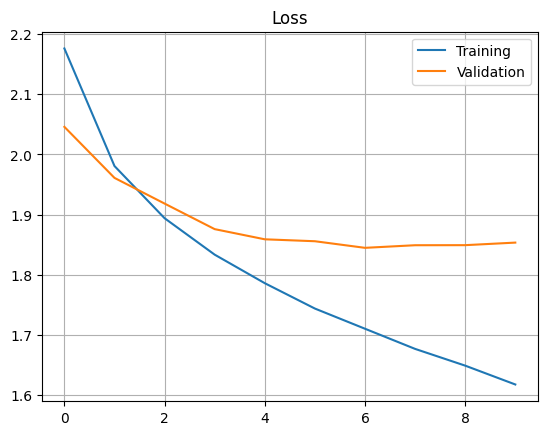

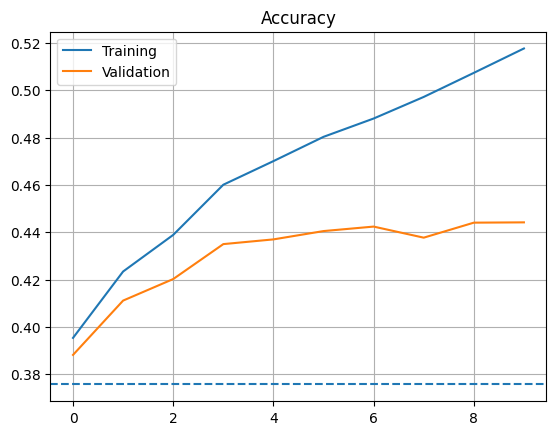

In [ ]:
# TEST plot_loss_accuracy
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies,
                   unigram_score)
# Don't clear the output of this cell!

##### i5.3 [2pt]

You should get accuracy above the baseline models discussed in Section 3 and 4. If your accuracy is lower than that, something is wrong.

However, even though you beat the baseline model, you probably noticed that the accuracy is not very high. Most likely, it is below 50 percent on the validation set. Yet, POS tagging is basically a solved task nowadays - POS taggers usually have accuracy around 98 or 99 percent.  
Why is it that this model has a much lower accuracy? Say in a few sentences why. Refer to the values in the plot that you printed in the previous cell.

**ANSWER** [50-100 words]: <font color="red">YOUR ANSWER HERE</font>  
<font color="orange">

The model constructed is a simple recurrent RNN. Hence, it does not consider bidirectional context. Moreover, even as regards left-context only, our simple RNN only takes into account the hidden state of the previous iteration, without any broader context.

As a result of these characteristics, the model is not able to perform as state of the art models in POS tagging. Validation loss is gradually decreasing from 2.05 of epoch 1 to 1.85 of epoch 9; also validation accuracy grows from 0.39 to 0.44; this overall means that the model is learning. However, LSTMs and Transformer models based on self-attention (e.g. BERT) perform uncomparably better on POS tagging, since they are capable of taking into account broader and bidirectional context.

### LSTM

So far, we only worked with a simple recurrent neural network (which only had a single hidden layer). There are, however, many other more elaborated recurrent neural networks. One such recurrent neural network is LSTM (long short-term memory), which was developed mainly to battle one issue that simple RNNs battle with: the fact that gradient tends to vanish, making it hard for simple RNNs to update its weights across long sequences.

#### TASK 6

Implement an LSTM model. For this task, you can use the class `torch.nn.LSTM`. Before the implementation, make sure to check more details on it ([link](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)).  
A few more notes: the code for your class should be similar to `FastSRN` but there is no specification for `hidden_activation` because activation across layers is already specified in the pytorch class. Second, make sure that you are using the unidirectional LSTM (if you used the bidirectional one, you would be predicting a POS tag based on preceding and following words, which is not what we want).
Also, keep the default value `batch_first=False` for the LSTM.

In [ ]:
# @title c6.1 [1pt]

class LSTMPredTag(torch.nn.Module):
    """
    LSTM module for predictions of POS tags using LSTM class in torch.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        output_activation: Callable[[FloatTensor], FloatTensor],
        num_layers: int = 1,
        device: str = 'cpu',
        seed: int = 42
    ) -> None:
        super().__init__()
        torch.manual_seed(seed)
        # YOUR CODE HERE

        self.device = device
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_activation = output_activation

        self.lstm = torch.nn.LSTM(input_size=input_dim,hidden_size=hidden_dim,num_layers=num_layers,bidirectional=False,batch_first=False, dropout = 0.2)

        self.proj = torch.nn.Linear(hidden_dim, output_dim)
        self.to(self.device)

        self.output_dropout = torch.nn.Dropout(0.5)

    def forward(self, X:FloatTensor, hprev: Optional[FloatTensor]=None) -> FloatTensor:
        """
        forward accepts a List of inputs X, an initial hidden vector hprev (h_{t−1})
        and iteratively applies step until the input sequence is exhausted,
        returning a List of outputs Y (of the same length as X).
        """
        # YOUR CODE HERE
        dev = self.proj.weight.device

        T, B, D = X.shape
        X_tbd = X.to(dev)



        if hprev is None:
            h0 = torch.zeros(self.num_layers, B, self.hidden_dim, device=dev)
            c0 = torch.zeros(self.num_layers, B, self.hidden_dim, device=dev)
        else:
            if isinstance(hprev, tuple):
                h0, c0 = hprev
            else:
                h0 = hprev
                c0 = torch.zeros_like(h0)
            h0 = h0.to(dev)
            c0 = c0.to(dev)

        # This is the output for the hidden dim
        out_tbh, _ = self.lstm(X_tbd, (h0, c0))

        # Here we map the output to the output dim (C)
        out_tbc = self.proj(out_tbh)
        out_tbc = self.output_activation(out_tbc)

        return out_tbc

Now, you can proceeed in the same way as with your RNN model.  
Note that the arguments of `training_model` function was selected in such a way that the function can also accept `LSTMPredTag` and train LSTM.

In [ ]:
# TEST c6.1
lstm, train_losses, val_losses, train_accuracies, val_accuracies = \
    training_model(LSTMPredTag, TRAIN_DL, VAL_DL, 10, device=DEVICE) # feel free to change device value
# Don't clear the output of this cell!

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 0
	Training / Validation Loss:     2.1300305012835574 / 1.925881645666859
	Training / Validation Accuracy: 0.42751601812783246 / 0.41737509731910444
Epoch 1
	Training / Validation Loss:     1.8332120904859328 / 1.8080043269212915
	Training / Validation Accuracy: 0.468272386310361 / 0.44982266296526396
Epoch 2
	Training / Validation Loss:     1.7199369228438826 / 1.747676831073862
	Training / Validation Accuracy: 0.4967358180965776 / 0.46672276441305766
Epoch 3
	Training / Validation Loss:     1.6368407183135583 / 1.7205158623438033
	Training / Validation Accuracy: 0.5194131895608689 / 0.4737218757618415
Epoch 4
	Training / Validation Loss:     1.5635634120726427 / 1.7075097390583582
	Training / Validation Accuracy: 0.5419264728863885 / 0.4776618249593029
Epoch 5
	Training / Validation Loss:     1.4913163238803282 / 1.7111322066140553
	Training / Validation Accuracy: 0.5666705735271136 / 0.4761047192884499
Epoch 6
	Training / Validation Loss:     1.416243484478123 / 1.728981041403

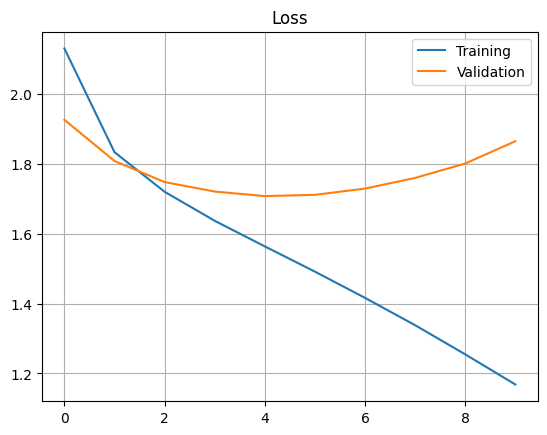

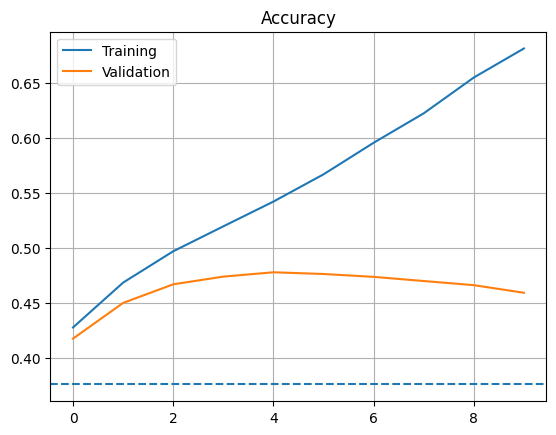

In [ ]:
# Let's plot the scores using the previously defined function
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, unigram_score)
# Don't clear the output of this cell!

If everything is correct, your LSTM model should beat your SRN model on both training and validation datasets (probably more so on the former).

By tweaking certain hyperparameters in the network and its training, we can get better performance on the validation set. Your task is to experiment with different values for hyperparameters that are supported by `training_model` function: neural newtork unit, hidden dimension, the number of hidden layers, and the number of epochs.  
After finding the combination of values that gives the highest accuracy on the validation set, provide the values below.  
Don't provide any code that you used to find the optimal combinatin of the values.  
Run the cell below with the optimal argument values and keep the output and plot. The score of your best model will be defined as the accuracy score on the validation set after the final epoch training.

Bonus points 5, 3, and 2 will be given to the groups whose best score will make to the top three.

<font color="red">**Just fill in the optimal values that you found, train the model and plot the scores!**</font> No need to submit any other code.

In [ ]:
# @title c6.2 [*]
# training the best model
best_model, train_losses, val_losses, train_accuracies, val_accuracies = \
    training_model(LSTMPredTag, # choose your own network class that you would like to train
                   TRAIN_DL, VAL_DL, # training and validation data
                   num_epochs=10, # max 10
                   hidden_dim=256, # whatever value you want
                   num_layers=2, # you can also have as many hidden layers as you want
                   device=DEVICE) # you should want gpu here
print(f"The best performance accuracy = {val_accuracies[-1]}")
# Don't clear the output of this cell!

Epoch 0
	Training / Validation Loss:     2.2138148571481766 / 1.958511194854817
	Training / Validation Accuracy: 0.41298640412564463 / 0.4103366651200466
Epoch 1
	Training / Validation Loss:     1.8836482512240378 / 1.8281797858142348
	Training / Validation Accuracy: 0.44992576965150805 / 0.4444042497974976
Epoch 2
	Training / Validation Loss:     1.7774604277894985 / 1.7645212020823564
	Training / Validation Accuracy: 0.47216361931551803 / 0.4609347352527151
Epoch 3
	Training / Validation Loss:     1.7077186647629896 / 1.7255547645861509
	Training / Validation Accuracy: 0.4887892639474918 / 0.471425538105836
Epoch 4
	Training / Validation Loss:     1.6538518498275454 / 1.7024622985294886
	Training / Validation Accuracy: 0.5025218784185029 / 0.47608112677828546
Epoch 5
	Training / Validation Loss:     1.6091861592223313 / 1.6890939871470134
	Training / Validation Accuracy: 0.5142776215033599 / 0.48029632192766536
Epoch 6
	Training / Validation Loss:     1.5693317388067183 / 1.676075849

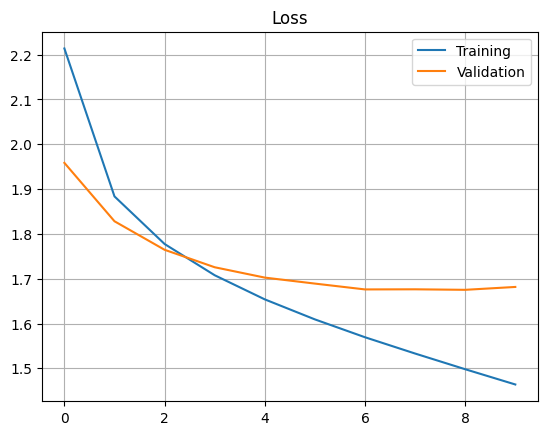

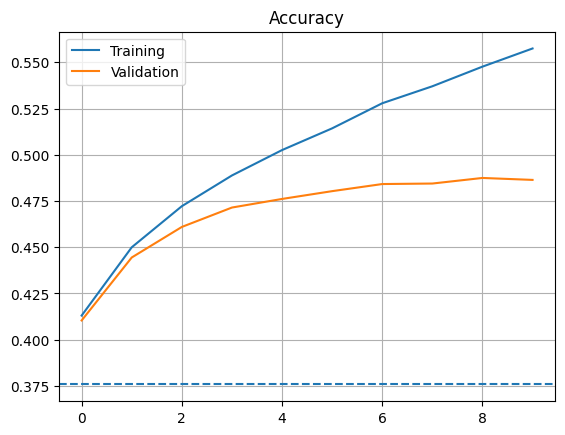

In [ ]:
# best model performance
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, unigram_score)
# Don't clear the output of this cell!

### Exploring the models

We will now start exploring the models. We will start with the error analyis, in which we will find sentences from the validation set where the network predicted wrong POS tags.

#### TASK 7

Complete the function `predict_and_contrast` that returns, for a list of sentences, a list of lists of (word, true_tag, predicted_tag) triplets when the prediction of the model does not correspond to the actual tag, and a tuple (word, true_tag) when the prediction is right. Note that for the first word in a sentence, the model makes no predictions - you can collect the first word along with `None` as its tag. Skip sentences with length one.
<font color="red">This means that no prediction is made for sentences with a single word (yes, there are such sentecnes) and they should be skipped.</font>

Concretely, for `['John sleeps .']`, assuming the model predicts VBZ and IN, the output should be:  
`[[('John', None), ('sleeps', 'VBZ'), ('.', '.', 'IN')]]`.

In [ ]:
# @title c7.1 [3pt]

def predict_and_contrast(nn: torch.nn.Module, sentences: list, tags: list, sent_vec: list, tag2idx: dict, verbose=False) -> list:
    """
    :param nn: the network representing a POS tagger
    :param sentences: the list of sentences
    :param tags: a list of list of tags (aligned with sentences)
    :param sent_vec: sentences with vectorized tokens
    :param tag2idx: mapping of tags to indices
    :param device: device for computation, defaults to the global DEVICE value
    :param verbose: when set to False, the function shouldn't print anything.
    this is provided in case you would like to print things while inspecting the function
    returns a list of sentences, where sentences are a list of tuples:
        (token, tag) for correctly tagged tokens and
        (token, reference_tag, predicted_tag) for wrongly tagged tokens
    """
    int_to_pos = {v: k for k, v in tag2idx.items()}
    all_predictions = []

    # YOUR CODE HERE
    int_to_pos = {v: k for k, v in tag2idx.items()}
    all_predictions = []

    nn.eval()
    device = next(nn.parameters()).device

    with torch.no_grad():
        for sent, sent_tags, vec in zip(sentences, tags, sent_vec):
            tokens = sent.split()

            # skipping sentences with only one word
            if len(tokens) <= 1:
                continue

            x = vec
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(1).to(device)


            out = nn(x)

            # ensuring to handle different outputs based on the nn used
            if out.dim() == 3:
                pred_idx = out.argmax(dim=-1)[:, 0]
            elif out.dim() == 2:
                pred_idx = out.argmax(dim=-1)


            T = pred_idx.shape[0]
            L = len(tokens)

            max_len = min(T, L-1)

            # don't predict the pos tag for the first word
            sent_result = [(tokens[0], None)]


            for t in range(1, max_len):
                word = tokens[t]
                true_tag = sent_tags[t]

                pred_tag_idx = int(pred_idx[t-1].item())
                pred_tag = int_to_pos.get(pred_tag_idx, None)

                if pred_tag == true_tag:
                    sent_result.append((word, true_tag))
                else:
                    sent_result.append((word, true_tag, pred_tag))

            all_predictions.append(sent_result)

            if verbose:
                print(sent_result)

    return all_predictions

In [ ]:
# it is up to you which model to use here: srn, lstm, or best_model
tok_gold_pred = predict_and_contrast(best_model, sentences_val, postags_val, X_val, pos_to_int)
# checking that single-word sentecnes are skipped
assert len(tok_gold_pred) == len([0 for tags in postags_val if len(tags) > 1])

/tmp/ipython-input-923869968.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


If you want to sanity check the implementation of the function. You could test whether you will get the same accuracy score from `tok_gold_pred` as the model got during the training-validation phase.

In [ ]:
# TEST c7.1
# Don't clear the output of this cell!
for s in tok_gold_pred[37:39]: # feel free to change the slice indices
    print(' '.join([ f"{t[0]}|{t[1]}" if len(t) < 3 else f"{t[0]}|{t[1]}|{t[2]}" for t in s ]))
    # we print just one tag when it is guessed correctly, two tags (true and predicted) when the model fails

Mr.|None Melloan|NNP 's|POS|VBD column|NN was|VBD|VBZ right|RB|VBN on|IN the|DT money|NN ,|,|NN but|CC I|PRP wish|VBP|VBD it|PRP|TO could|MD have|VB gone|VBN one|CD|IN step|NN further|RBR|.
How|None unprofessional|JJ|MD we|PRP|NNS must|MD|VBP have|VB appeared|VBN to|TO|IN the|DT|VB outside|JJ|NN world|NN|IN --|IN how|WRB|CC incompetent|JJ|PRP at|IN|NNP risk|NN|DT assessment|NN|. and|CC|. evaluation|NN|DT ,|,|IN he|PRP says|VBZ


##### i7.2 [2pt]

Among the examples printed by the above code cell, **find two examples** where the model successfully predicts the POS tag of an upcoming word and **two examples where it fails** to do so. All the examples could be from the same or different sentences.

Describe what you observe for these cases. Does the model behave according to your intuitions? Does it get the prediction correct when it should be possible? Does it fail when it is hard to get the prediction right? <font color="red">Be concrete with your answer and use examples.</font>

**ANSWER** [30-80 words]: <font color="red">YOUR ANSWER HERE</font>  

Correctly preddicted:
- "Melloan": NNP;
- "have" VB;

Misclassifications:
- "'s": VBD instead of POS;
- "outside": NN instead of JJ;

The model behaves as expected and predicts the right POS tag in cases where it is possible: for example, after the word "Mr.", one would expect a proper noun. The model, in fact, predicts NNP.

The model also makes mistakes when prediction is hard. After the sequence "to the...", one would expect a noun ( e.g, "to the museum", "to the collegues"). In fact, the model predicts NN, while actually there was an adjective first "outside word".






Finally, find an answer to the following question regarding the validation set: which POS tag is most often correctly predicted? And which one is most often not predicted by the model?

To get such tags, complete `tag_accuracy_cnt` function that takes predictions of the POS tags of an upcoming word and a cut-off value and returns a list of tuples of `('TAG', accuracy_score, number_of_occurrences_of_TAG)`. Note that `number_of_occurrences_of_TAG` should not be less than the cut-off value. The elements in the list are sorted in descending order of the accuracy score. The cut-off value helps to ignore rare POS tags that might be difficult/easy to predict because of their infrequency.

In [ ]:
# @title c7.3 [2pt]

def tag_accuracy_cnt(tok_gold_predictions: List[tuple], freq_cut_off: int=100, verbose=False) -> List[tuple]:
    """
    :param tok_gold_predictions: a list of sentences, where sentences are a list of tuples:
        (token, tag) for correctly tagged tokens and
        (token, reference_tag, predicted_tag) for wrongly tagged tokens
    :param freq_cut_off: to ignore tags that are occurring less frequently
    :param verbose: when set to False, the function shouldn't print anything.
    this is provided in case you would like to print things while inspecting the function
    returns a list of tuples of (tag, tag_specific_accuracy_score, number_of_occurrences_of_tag)
    the list is sorted in descending order of the accuracy score
    """

    # Counters
    tag_correct = defaultdict(int)
    tag_total = defaultdict(int)

    for sent in tok_gold_predictions:
        for tok_tuple in sent:
            # Skip the first token
            if len(tok_tuple) == 2 and tok_tuple[1] is None:
                continue

            # Correctly predicted token
            if len(tok_tuple) == 2:
                _, true_tag = tok_tuple
                tag_correct[true_tag] += 1
                tag_total[true_tag] += 1

            # Incorrectly predicted token
            elif len(tok_tuple) == 3:
                _, true_tag, _ = tok_tuple
                tag_total[true_tag] += 1

    # Compute accuracy and filter by cutoff
    tag_stats = []
    for tag, total in tag_total.items():
        if total >= freq_cut_off:
            acc = tag_correct[tag] / total
            tag_stats.append((tag, acc, total))

    # Sort
    tag_stats.sort(key=lambda x: x[1], reverse=True)

    if verbose:
        print(f"Total tags considered (cutoff={freq_cut_off}): {len(tag_stats)}\n")
        for tag, acc, count in tag_stats[:10]:
            print(f"{tag:<10} accuracy={acc:.3f}  count={count}")

    return tag_stats

In [ ]:
# TEST c7.3
tag_score_cnt = tag_accuracy_cnt(tok_gold_pred)

assert all([ 0 <= i[1] <= 1 for i in tag_score_cnt ]) # probability check
assert tag_score_cnt[0][1] > tag_score_cnt[-1][1] # sorting check

tag_score_cnt
# Don't clear the output of this cell!

[('VB', 0.9026930894308943, 3936),
 ('NN', 0.663157323492701, 18427),
 ('CD', 0.6476389152285227, 5273),
 ('DT', 0.6250956388676359, 10456),
 ('VBP', 0.6185622317596566, 1864),
 ('VBN', 0.5771662328002976, 2689),
 ('IN', 0.5451312703336612, 13217),
 ('NNP', 0.5432162092844319, 11697),
 ('$', 0.5227722772277228, 1010),
 ('VBD', 0.5085765203831588, 4489),
 ('NNS', 0.4755288521717361, 7989),
 (';', 0.4715909090909091, 176),
 ('RRB', 0.45625, 160),
 ('VBZ', 0.44223716381418093, 3272),
 (',', 0.4330590875093493, 6685),
 ('TO', 0.4196288140924819, 3179),
 ('POS', 0.35814722911497104, 1209),
 ('PRP', 0.25022542831379624, 2218),
 ('VBG', 0.22882181110029212, 2054),
 ('CC', 0.2273781902552204, 3017),
 ('RP', 0.21079691516709512, 389),
 ('LRB', 0.17721518987341772, 158),
 ('RB', 0.16055595494847832, 4173),
 ('WP', 0.12779552715654952, 313),
 ('JJ', 0.12682991748735695, 7514),
 ('WDT', 0.12255772646536411, 563),
 ('MD', 0.11391541609822646, 1466),
 ('JJS', 0.10305343511450382, 262),
 ('RBR', 0.08

##### i7.4 [2pt]

Pick any POS tag at the beginning of the list (i.e., frequently correctly predicted tags) and any POS tag at the end of the list (i.e., frequently wrongly predicted tags). Provide rationale why these POS tags are often correctly and wrongly predicted.  
<font color="red">Be concrete with your answer and use examples to support your explanation.</font>

**ANSWER** [30-80 words]: <font color="red">YOUR ANSWER HERE</font>  

Among the most accurately classified, we can find NN (0.663 accuracy) abd VB (0.902 accuracy). Among the POS tags that are often, or even always, misclassified by the model there are NNPS (0.0 accuracy), WRB (0.02 accurcay), JJR (0.01 accuracy). Likely, the model learned well how to classify NN and VB because those are among the most widespread POS tags in the corpus (in particular NN). On the other hand, POS tags such as JJR or WRB are barely present in the training set and hence the model did not learn well their patterns.

### RNNs and human sentence processing

We now move on to psycholinguistics and sentence processing.

You might have wondered up to now: what is the point of the model predicting a POS tag of the upcoming word? Who needs that? Would it not be easier to simply wait for the word and assign the POS tag when we observe it? Indeed, that would make the correctness of POS labels for a sequence go way up. Such a task is much much easier.

The reason we want to predict a POS tag is not to get POS labels right: we actually do not care about them at all; we do this to *get a model that can be useful to study human sentence processing* (just like we let language models predict, not observe the upcoming word, to create models that reflects human creativity and language competence). So the real question is: is our model a good approximation of human sentence processing?

We know that people constantly predict upcoming text, including abstract information like categories. When the actual text does not match our predictions, cognitive difficulties ensue. Such difficulties can be very subtle and only measurable with techniques like eye tracking or EEG (when the mismatch between predictions and the actuality is small) or can be very robust and observable even by, say, introspections (e.g., some sentences might feel odd). In order to know whether our model is any good as a model of processing, we need to know whether there is correspondence between (i) good/bad predictions of our models and (ii) cognitive easiness/difficulties experiences by language users? We explore that in Task 8.

#### TASK 8

We want to first measure how surprising a particular outcome is. The standard measure for this is *surprisal*. *Surprisal* is a log of inverse probability. That is, if our model predicts that a particular POS appears with the probability $p$, we calculate its suprisal $s$ as:
$s=\log(1/p)=-\log(p)$

With this background, implement the function `get_surprisals`, which returns, for a list of sentences, a list of lists of tuples (word, true_tag, $s$) where $s$ is the surprisal value that the model has for *true tag*. The function to some extent does the same initial steps as `predict_and_contrast`.  
<font color="red">_Hint_: you should take into account what the output vector of the RNN model represents and how it is related to a log-probability distribution over POS tags.

In [ ]:
# @title c8.1 [3pt]
def get_surprisals(nn, sentences: list, tags: list, sent_vec: list, tag2idx: dict, verbose=False):
    """
    :param nn: the network representing a POS tagger
    :param sentences: the list of sentences
    :param tags: a list of list of tags (aligned with sentences)
    :param sent_vec: sentences with vectorized tokens
    :param tag2idx: mapping of tags to indices
    :param verbose: when set to False, the function shouldn't print anything.
    this is provided in case you would like to print things while inspecting the function
    returns a list of sentences, where sentences are a list of tuples:
        (token, reference_tag, surprisal)
    """
    # YOUR CODE HERE

    all_surprisals = []

    nn.eval()
    device = next(nn.parameters()).device

    with torch.no_grad():
        for sent, sent_tags, vec in zip(sentences, tags, sent_vec):
            tokens = sent.split()


            if len(tokens) <= 1:
                continue

            x = torch.tensor(vec, dtype=torch.float32)
            x = x.unsqueeze(1).to(device)

            out = nn(x)

            if out.dim() == 3:
                out = out[:, 0, :]

            # convert to log-probabilities over tags
            log_probs = torch.nn.functional.log_softmax(out, dim=-1)

            T = log_probs.shape[0]
            L = len(tokens)

            max_len = min(T, L)
            sent_result = []

            for t in range(1, max_len):
                word = tokens[t]
                true_tag = sent_tags[t]
                true_idx = tag2idx[true_tag]
                log_p_true = log_probs[t - 1, true_idx].item()
                surprisal = -log_p_true

                sent_result.append((word, true_tag, surprisal))

            all_surprisals.append(sent_result)

            if verbose:
                print(sent_result)

    return all_surprisals



In [ ]:
# TEST c8.1
sent_tags_surp = get_surprisals(lstm, sentences_val, postags_val, X_val, pos_to_int)

assert all([ len(t) == 3 for s in sent_tags_surp for t in s ]) # basic sanity-check for the format

/tmp/ipython-input-2075504289.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(vec, dtype=torch.float32)


Now, check the code on a few sentences from the validation set. You should see that often, where the model was off with its prediction (as noticed in Task 7), the surprisal should be higher, where it was correct, it should be lower.

In [ ]:
# we check the surprisal values for 2 sentences (feel free to pick your own sentences)
for s in sent_tags_surp[48:50]: # feel free to change the slice indices
    print('\n'.join([ f"{t[0]}|{t[1]}|{t[2]:.6f}" for t in s  ]), end="\n\n") # we translate surprisal back to probabilities

rose|VBD|0.154521
14|CD|0.223275
%|NN|0.000213
to|TO|0.059567
$|$|0.012463
4.03|CD|0.000023
billion|CD|0.000010
from|IN|0.197983
$|$|0.001853
3.54|CD|0.000005
billion|CD|0.000021

the|DT|1.410149
Pennsylvania|NNP|2.428868
measure|NN|0.945747
also|RB|2.220585
includes|VBZ|0.661460
an|DT|1.146769
informed|JJ|0.727156
consent|NN|0.166289
provision|NN|1.493902
that|WDT|6.752781
may|MD|4.966288
become|VB|0.130981
widely|RB|3.383737
imitated|VBN|0.438323
by|IN|0.321380
abortion|NN|3.412375
foes|NNS|2.446432
who|WP|4.951940
want|VBP|0.152163
to|TO|0.313087
make|VB|0.001935
women|NNS|2.029458
contemplating|VBG|4.882183
abortion|NN|3.943425
as|RB|4.240539
uncomfortable|JJ|2.032795
as|IN|1.246710
possible|JJ|3.216086
with|IN|2.636144
the|DT|0.116846
procedure|NN|1.144264
and|CC|2.959928
with|IN|4.025138
themselves|PRP|2.895495



Finally, let's check the average surprisal per POS tag. What POS has the lowest average surprisal? And what POS has the highest surprisal? The result should be correlated with the accuracy scores per tag: more predictable tags get lower surprisal and less predictable tags higher surprisal.

In [ ]:
# @title c8.2 [1pt]
def tag_surprisal(sent_tag_surp: list, cut_off: int=100, verbose=False) -> list:
    """
    :param sent_tag_surp: a list of sentences, where sentences are a list of tuples:
        (token, correct POS tag, surprisal of the POS tag)
    :param cut_off: the minimum number of occurrences of a POS tag
    :param verbose: when set to False, the function shouldn't print anything.
    this is provided in case you would like to print things while inspecting the function
    return a list of tuples of (tag, float_average_surprisal, number_of_occurrences_of_tag)
    the list is sorted in ascending order of the average_surprisal
    """
    # YOUR CODE HERE

    tag_sum = {}
    tag_count = {}

    for sent in sent_tag_surp:
        for token, tag, s in sent:
            tag_sum[tag] = tag_sum.get(tag, 0.0) + float(s)
            tag_count[tag] = tag_count.get(tag, 0) + 1

    # apply the cutoff
    results = []
    for tag, count in tag_count.items():
        if count >= cut_off:
            avg_s = tag_sum[tag] / count  # compute the average
            results.append((tag, avg_s, count))

    # sort by average surprisal
    results.sort(key=lambda x: x[1])

    if verbose:
        for tag, avg_s, count in results:
            print(f"{tag}\tcount={count}\tavg_surprisal={avg_s:.4f}")

    return results



In [ ]:
# TEST c8.2
tag_avg_surp = tag_surprisal(sent_tags_surp, cut_off=100)

assert all([ len(i) == 3 for i in tag_avg_surp ]) # basic format check
assert tag_avg_surp[0][1] < tag_avg_surp[-1][1] # sorting check

tag_avg_surp

[('VB', 0.6245280896078119, 3936),
 ('NN', 1.2983163822976562, 18427),
 ('CD', 1.328354590759349, 5273),
 ('NNP', 1.4146687761663659, 11697),
 ('DT', 1.5314033706345753, 10456),
 ('IN', 1.5945923138757585, 13217),
 ('VBD', 1.7262179678868013, 4489),
 ('VBP', 1.7614202373910919, 1864),
 ('NNS', 1.765210784443671, 7989),
 (',', 1.7991526337681796, 6685),
 ('VBN', 1.9902070689421354, 2689),
 ('$', 1.9980984882818489, 1010),
 ('VBZ', 2.055023333796671, 3272),
 ('TO', 2.3412300717619816, 3179),
 ('JJ', 2.3672750036862804, 7514),
 ('POS', 2.5445025830771897, 1209),
 ('PRP', 2.703253480508366, 2218),
 ('MD', 2.7537975631867715, 1466),
 ('CC', 2.8070693915869853, 3017),
 ('RB', 2.883361782451474, 4173),
 ('RRB', 3.083359856698735, 160),
 ('VBG', 3.1323421560046505, 2054),
 ('RP', 3.305305106972361, 389),
 ('PRP$', 3.7409170513555012, 1173),
 (';', 3.8159561205042833, 176),
 ('JJS', 3.923985515074193, 262),
 ('WDT', 4.079805894203973, 563),
 ('WP', 4.17117935270309, 313),
 ('NNPS', 4.3922006698

#### TASK 9

One famous case of processing difficulties is represented by [garden-path sentences](https://en.wikipedia.org/wiki/Garden-path_sentence): sentences that are hard to parse. The reason that garden path sentences are hard to parse is because they do not match our expectations.

Do we see the same with the models?

Below, we collected sentences (printed in pairs, such that the first element in the pair is a garden-path sentence, the second element is a minimally different sentence which carries the same interpretation but which is not garden path because the expected interpretation is signalled early on). The comments show names under which such garden path constructions are categorized in literature.

In [ ]:
# some examples
gps = [
    "The banker informed about the recession resigned .", "The banker who was informed about the recession resigned .", # main-clause/reduced relative ambiguity
    "Before the manager walks the dog is happy .", "Before the manager walks , the dog is happy .", # NP/Z ambiguity
    "I saw the students danced .", "I saw that the students danced .", #NP/S ambiguity
    "The man put the book on the towel into the box", "The man put the book that was on the towel into the box", #PP ambiguity
    # ADD NEW SENTENCE PAIR (see i9): garden path and its disambiguated version
    "The student shared the information retrieved with his group members", "The student shared the information that he retrieved with his group members" #PP ambiguity
    ]


We let `spaCy` create docs out of the sentences (just as we did for training and validation), then we collect POS tags as generated by `spaCy` and create tensors for words and tags. Fortunately, spaCy's POS tagger is enough precise to tag the given sentences correctly.

In [ ]:
gps_docs = [ spacy.tokens.doc.Doc(nlp.vocab, words=s.split()) for s in gps ]

gps_postags = [ [word.tag_ for word in nlp(s)] for s in gps ]

print(gps_postags)

# convert to tensors
gps_vectors = [ np.array([word.vector for word in doc]) for doc in gps_docs ]
gps_tensors = [ torch.tensor(sentence_vectors) for sentence_vectors in gps_vectors ]

[['DT', 'NN', 'VBD', 'IN', 'DT', 'NN', 'VBD', '.'], ['DT', 'NN', 'WP', 'VBD', 'VBN', 'IN', 'DT', 'NN', 'VBD', '.'], ['IN', 'DT', 'NN', 'VBZ', 'DT', 'NN', 'VBZ', 'JJ', '.'], ['IN', 'DT', 'NN', 'VBZ', ',', 'DT', 'NN', 'VBZ', 'JJ', '.'], ['PRP', 'VBD', 'DT', 'NNS', 'VBD', '.'], ['PRP', 'VBD', 'IN', 'DT', 'NNS', 'VBD', '.'], ['DT', 'NN', 'VBD', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN'], ['DT', 'NN', 'VBD', 'DT', 'NN', 'WDT', 'VBD', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN'], ['DT', 'NN', 'VBD', 'DT', 'NN', 'VBN', 'IN', 'PRP$', 'NN', 'NNS'], ['DT', 'NN', 'VBD', 'DT', 'NN', 'WDT', 'PRP', 'VBD', 'IN', 'PRP$', 'NN', 'NNS']]


##### i9 [5pt]

Run your models on the sentences and collect surprisals for both LSTM and SRN models.

Inspect and describe the results. Do models capture any of the cases right?

When answering these questions, keep in mind that we do not care about surprisal values for all words. **We only care about surprisal values for those words at which people experience surprises about the sentences**: these are the verbs 'resigned', 'is', 'danced', and the preposition 'into' in the examples above.  
Do the models assign higher surprisals/lower probabilities to the target words in garden paths compared to minimally different sentences? Make sure to use the provided examples to support your answer.  
And do the two models differ? If so, speculate why this might be.  
**Also, add one extra pair of a garden path and discuss its surprisal values.**

In [ ]:
# YOUR CODE HERE; obviously, you should use already defined function(s)
# Don't clear the output of this cell!

LSTM_surprisal = get_surprisals(lstm, gps, gps_postags, gps_tensors, pos_to_int)
print("LSTM_surprisal:")
print(LSTM_surprisal[0][5],LSTM_surprisal[1][7])
print(LSTM_surprisal[2][5],LSTM_surprisal[3][6])
print(LSTM_surprisal[4][3],LSTM_surprisal[5][4])
print(LSTM_surprisal[6][7],LSTM_surprisal[7][9])
print(LSTM_surprisal[8][4],LSTM_surprisal[9][6])

SRN_surprisal = get_surprisals(srn, gps, gps_postags, gps_tensors, pos_to_int)
print("SRN_surprisal:")
print(SRN_surprisal[0][5],SRN_surprisal[1][7])
print(SRN_surprisal[2][5],SRN_surprisal[3][6])
print(SRN_surprisal[4][3],SRN_surprisal[5][4])
print(SRN_surprisal[6][7],SRN_surprisal[7][9])
print(SRN_surprisal[8][4],SRN_surprisal[9][6])

LSTM_surprisal:
('resigned', 'VBD', 4.064397811889648) ('resigned', 'VBD', 5.8140716552734375)
('is', 'VBZ', 3.928901195526123) ('is', 'VBZ', 1.980586290359497)
('danced', 'VBD', 0.8690497875213623) ('danced', 'VBD', 0.39900028705596924)
('into', 'IN', 0.7121407389640808) ('into', 'IN', 0.643756091594696)
('retrieved', 'VBN', 5.260326385498047) ('retrieved', 'VBD', 0.4253465533256531)
SRN_surprisal:
('resigned', 'VBD', 1.3600201606750488) ('resigned', 'VBD', 4.8549394607543945)
('is', 'VBZ', 4.369724750518799) ('is', 'VBZ', 2.6114847660064697)
('danced', 'VBD', 2.1785202026367188) ('danced', 'VBD', 2.519988536834717)
('into', 'IN', 1.378732442855835) ('into', 'IN', 0.9282723665237427)
('retrieved', 'VBN', 4.905216217041016) ('retrieved', 'VBD', 0.9741759300231934)


/tmp/ipython-input-2075504289.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(vec, dtype=torch.float32)


**ANSWER** [100-250 words]: <font color="red">YOUR ANSWER HERE</font>

As can be seen above, the garden path sentences show a higher surprisal value in both models for 'is' (LSTM changed from 3.92 to 1.98 (GP), SRN from 4.36 (GP) to 2.61) and 'into' (LSTM changed from 0.71 (GP) to 0.64, SRN from 1.37 (GP) to 0.92), as well as our own added 'retrieved' (LSTM changed from 5.26 (GP) to 0.42, SRN from 4.9 (GP) to 0.07), so these models are able to notice the structural difference in the small differences in sentences. 'Resigned' scores higher in the normal version of the sentence (and high for GP as well) since the model doesn't expect this word, likely since it is distant to banker and expects the sentence to go on about informed instead. With regard to the difference between the models: both models show similar surprisal values, but the LSTM model sometimes performs a bit better, while for some words the difference is small. This is most likely because the SRN model relies on local word occurrence instead of clause-level cues. In another case, for 'is', SRN performs better, most likely because SRN focusses on the local change more than LSTM.

#### TASK 10

Another way to test the memory ability of the model is to look at center-embedding structures. Three examples are given here, with the increasing level of embedding.

In [ ]:
center_embedding_sentences = [
      # Depth 0
      "The student passed .",

      # Depth 1
      "The student that the teacher helped passed .",

      # Depth 2
      "The student that the teacher that the principal hired helped passed .",

      # Depth 3 - come up with your own example
      "The student that the teacher that the principal that the policeman caught hired helped passed .",
  ]
wrong_center_embedding_sentences = [
      # Depth 0
      "The student .",

      # Depth 1
      "The student that the teacher helped .",

      # Depth 2
      "The student that the teacher that the principal hired helped .",

      # Depth 3 - match your own example of depth 3 from center_embedding_sentences
      "The student that the teacher that the principal that the policeman caught hired helped .",
  ]

In [ ]:
# YOUR CODE HERE; obviously, you should use already defined function(s)
# Don't clear the output of this cell!

ces = center_embedding_sentences + wrong_center_embedding_sentences
# print(ces)

ces_docs = [ spacy.tokens.doc.Doc(nlp.vocab, words=s.split()) for s in ces ]

ces_postags = [ [word.tag_ for word in nlp(s)] for s in ces ]

# print(ces_docs)

# convert to tensors
ces_vectors = [ np.array([word.vector for word in doc]) for doc in ces_docs ]
ces_tensors = [ torch.tensor(sentence_vectors) for sentence_vectors in ces_vectors ]

LSTM_ces = get_surprisals(lstm, ces, ces_postags, ces_tensors, pos_to_int)
print("LSTM_ces:")
# print(LSTM_ces)
print("D0 correct",LSTM_ces[0][1],"wrong",LSTM_ces[4][1])
print("D1 correct",LSTM_ces[1][-2],"wrong",LSTM_ces[5][-1])
print("D2 correct",LSTM_ces[2][-2],"wrong",LSTM_ces[6][-1])
print("D3 correct",LSTM_ces[3][-2],"wrong",LSTM_ces[7][-1])

SRN_ces = get_surprisals(srn, ces, ces_postags, ces_tensors, pos_to_int)
print("SRN_ces:")
# print(SRN_ces)
print("D0 correct",SRN_ces[0][1],"wrong",SRN_ces[4][1])
print("D1 correct",SRN_ces[1][-2],"wrong",SRN_ces[5][-1])
print("D2 correct",SRN_ces[2][-2],"wrong",SRN_ces[6][-1])
print("D3 correct",SRN_ces[3][-2],"wrong",SRN_ces[7][-1])


LSTM_ces:
D0 correct ('passed', 'VBD', 1.633778691291809) wrong ('.', '.', 9.95512866973877)
D1 correct ('passed', 'VBN', 6.320742607116699) wrong ('.', '.', 10.208550453186035)
D2 correct ('passed', 'VBN', 7.468993186950684) wrong ('.', '.', 8.821405410766602)
D3 correct ('passed', 'VBN', 6.425394058227539) wrong ('.', '.', 7.114715576171875)
SRN_ces:
D0 correct ('passed', 'VBD', 2.582017421722412) wrong ('.', '.', 7.168196678161621)
D1 correct ('passed', 'VBN', 7.46103048324585) wrong ('.', '.', 5.852938175201416)
D2 correct ('passed', 'VBN', 5.921045780181885) wrong ('.', '.', 5.051710605621338)
D3 correct ('passed', 'VBN', 4.849461078643799) wrong ('.', '.', 3.7289233207702637)


/tmp/ipython-input-2075504289.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(vec, dtype=torch.float32)


##### i10 [4pt]

For the center embedding sentences, add an example of depth 3 (both for the correct and wrong case).

Then, use the code from previous tasks to calculate the surprisal value on the matrix verb (the verb *passed*) in center embedding sentences, and compare that to the surprisal value on the end of the sentence sign (.) in the wrong center embedding sentences.

In the latter dataset, are SRN and LSTM correctly surprised that the matrix verb is missing? Motivate your answer.
Does the behavior change with the increase of depth? Motivate your answer.   
If it changes, explain why you think this is the case.  
If you see differences between SRN and LSTM, describe the pattern and explain why you think the two cases differ.

**ANSWER** [100-250 words]: <font color="red">YOUR ANSWER HERE</font>

- For all sentences, both models are surprised about the '.' (and thus the missing verb), since the surprisal values are high for all wrong sentences. It is interesting to see that they actually get less surprised when the depth increases. LSTM goes from 10.2 for D1 to 7.11 for D3, and SRN goes from 5.85 for D1 to 3.72 for D3.
- We suppose this change is because the addition to other verbs at the end leads to a higher probability that the sentence can be ended, and that both models aren't quite able to keep track of (or care about) how many verbs should be present.
- Both models are less surprised about 'passed' when depth is zero, since there is no embedding present, however they both struggle to see the link with student and passed when there are embedded clauses and accompanying verbs. Interesting difference is that with the SRN model, the surprise for 'passed' jumps up at D1 (7.46) and then goes down again for D2 (5.92) and D3 (4.84), while LSTM stays high after the initial jump (around 6 or 7). For LSTM this leads to the verb as last word is less surprising than '.', while SRN is more surprised of the verb than '.' in all embedded sentences.This indicates the LSTM is better able to keep track of the expected number of verbs required to finalise all (embedded) sentences than the SRN.

# <font color="red">Work description</font>

~~Describe your approach to solving the exercises, for example, what steps you took first, followed by subsequent actions, which parts you found most challenging or easy, any specific helpful assistance received from TAs, whether you used GenAI, to what extent, at what stage, which one, how helpful was it, etc.~~

<font color="red">YOUR ANSWER HERE</font>   [100-200 words]

Similar to Assignment 2A, we mainly used information in the assignment itself, the lecture slides and eventually stackoverflow / geeksforgeeks to find the required information to solve the coding exercises. Next to that we've used ChatGPT for debugging purposes. We also used ChatGPT to guide us when the output of our code wasn't as we expected, to show us what parts of the code were leading to these results. For example in assignment 10, we noticed that the code for c8.1 cut off the '.' when surprisal was calculated, after fixing this, it all worked. For this assignment, worked on it regularly outside of the lectures and texted about the plans. We made sure that, when one of us had individually done a part of the assignment, the other then also followed the logic and could replicate the answer too to make sure we both would learn from this exercise.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
The changes, including adaptation to the Colab environment and formulation of several coding tasks in terms of functions, are by Lasha Abzianidze.  
Modeling surprisal of the upcoming word's POS tag was added by Jakub Dotlacil.